Find all the chips in a FOV at different declinations to see whether the chipRADec-XY conversion is ok.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time
import pandas as pd
import copy
import lsst.sims.maf.slicers as slicers
import healpy as hp
import lsst.sims.maf.metricBundles as metricBundles
repoDir= os.getcwd()
os.chdir(os.path.join(repoDir , '..' ))
repoDir= os.getcwd()
from intermediates import *
from plotFunctions import *
from astropy import units as u
from astropy.coordinates import SkyCoord, Galactic
from lsst.obs.lsstSim import LsstSimMapper
from lsst.sims.utils import ObservationMetaData
from lsst.sims.coordUtils import chipNameFromRaDec

In [2]:
path= '/Volumes/Transcend/'
path2= '2017-01-11/coaddM5Analysis_nside256_withDustExtinction_14pixelRadiusForMasking_rBand_minion1016_fullSurveyPeriod_directory/'
path3= 'maskedCoaddData/'
os.chdir(path+path2+path3)

# get the saved files
filenames = ['coaddM5Data_masked_r_NoDither.npz', 
             'coaddM5Data_masked_r_RandomDitherFieldPerVisit.npz']

coaddBundle= {}
for i in range(len(filenames)):
    mB = metricBundles.createEmptyMetricBundle()
    mB.read(filenames[i])
    dithStrategy= mB.metadata.strip()   # key is assigned to be the same as dithStrategy
    print 'Filename for ' + dithStrategy + ': ', filenames[i]
    print ''

    coaddBundle[dithStrategy]= mB

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Filename for NoDither:  coaddM5Data_masked_r_NoDither.npz

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Filename for RandomDitherFieldPerVisit:  coaddM5Data_masked_r_RandomDitherFieldPerVisit.npz



### Read in OpSim data.

In [3]:
dbpath = path+'minion_1016_sqlite_new_dithers.db'   # new afterburner output
extraCols= ['expDate', 'obsHistID','ditheredRotTelPos', 'rotTelPos']
simdata= getSimData(dbpath, 'r', extraCols= extraCols, newAfterburner= True)

In [4]:
def getSurveyHEALPixRADec(coaddBundle):
    """

    Modified from the one in the repo: want all the pixels; not the ones in the unmasked region of the survey.
    
    Get the RA, Dec (in radians) corresponding to each HEALPix pixel.
    Method returns a dictionary with keys= keys in coaddBundle: pixelNumber

    Required Parameter
    ------------------
    * coaddBundle: dict: dictionary with keys= observing strategy names, pointing to
                         corresponding to a metricBundle object.

    """
    # create dictionaries giving pixelNumbers and their correspondong RA, Dec for all dither strategies.
    # need to worry about each strategy separately since the mask is generally different.
    pixelNum= {}
    for dither in coaddBundle:
        pixelNum[dither]= []
        for pix in range(len(coaddBundle[dither].slicer)):
            #if not coaddBundle[dither].metricValues.mask[pix]:   # only consider the unmasked pixels
            pixelNum[dither].append(pix)

    return pixelNum

In [5]:
pixelNum= getSurveyHEALPixRADec(coaddBundle)   # each output is a dicitonary.

In [6]:
pixels_in_FOV= getFOVsHEALPixReln(pixelNum, simdata, nside= 256) # each output is a dicitonary.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Number of fieldIDs in pixel_in_FOV for RandomDitherFieldPerVisit: 2293


In [7]:
ids, pointingRAs, pointingDecs, pointingbs= [], [], [], []
for fid in np.unique(simdata['fieldID']):
    #print fid
    ind= np.where(simdata['fieldID']==fid)[0]
    
    pointingRA= simdata['fieldRA'][ind][0]  #[index]  # poiting RA
    pointingDec= simdata['fieldDec'][ind[0]]    #[index]   # pointin Dec
    
    ids.append(fid)
    pointingRAs.append(pointingRA)
    pointingDecs.append(pointingDec)
    c= SkyCoord(ra= pointingRA*u.radian, dec= pointingDec*u.radian)

    pointingbs.append(c.transform_to(Galactic).b.radian)

In [8]:
pointingbs= np.array(pointingbs)
pointingRAs= np.array(pointingRAs)
pointingDecs= np.array(pointingDecs)
ids= np.array(ids)

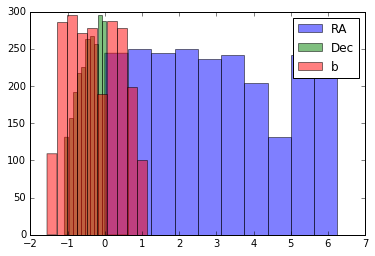

In [9]:
plt.hist(pointingRAs, alpha= 0.5, label= 'RA')
plt.hist(pointingDecs, alpha= 0.5, label= 'Dec')
plt.hist(pointingbs, alpha= 0.5, label= 'b')
plt.legend()

In [10]:
index= np.where(abs(pointingDecs) == min(abs(pointingDecs)))[0]
print 'index ', index
print 'b ', pointingbs[index]
print 'ra ', np.degrees(pointingRAs[index])
print 'dec ', np.degrees(pointingDecs[index])
print 'id ', ids[index]

print ''
index= np.where(pointingDecs == min(pointingDecs))[0]
print 'index ', index
print 'b ', pointingbs[index]
print 'ra ', np.degrees(pointingRAs[index])
print 'dec ', np.degrees(pointingDecs[index])
print 'id ', ids[index]


print ''
index= np.where(pointingbs == min(pointingbs))[0]
print 'index ', index
print 'b ', pointingbs[index]
print 'ra ', np.degrees(pointingRAs[index])
print 'dec ', np.degrees(pointingDecs[index])
print 'id ', ids[index]

index  [2164 2165 2166 2167 2168 2169 2170 2171 2172 2173 2174]
b  [-0.60441539 -0.94397579  0.4486339   0.05376234 -0.65015374 -0.97770764
  0.97770802  0.65015346 -0.4486342   0.94397621  0.60441593]
ra  [ 322.4171596    37.5828228   253.58281224  106.41722746  325.58286601
   34.41717368  214.41713624  145.58284616   73.58279239  217.58278535
  142.41719705]
dec  [-0.1873572 -0.1873572 -0.1873572 -0.1873572 -0.1873572 -0.1873572
  0.1873572  0.1873572  0.1873572  0.1873572  0.1873572]
id  [2641 2642 2643 2644 2645 2646 2647 2648 2650 2651 2652]

index  [0 1]
b  [-0.11925987 -0.28381557]
ra  [ 240.05533599  119.94464641]
dec  [-62.02119163 -62.02119163]
id  [309 310]

index  [984]
b  [-1.55110164]
ra  [ 12.77529725]
dec  [-28.25421046]
id  [1397]


In [11]:
idsToConsider= [2644, 310, 1397]

In [12]:
print idsToConsider

[2644, 310, 1397]


In [13]:
for ID in idsToConsider:
    print 'id ', ID
    index= np.where(ids==ID)[0]
    print 'b ', pointingbs[index]
    print 'ra ', np.degrees(pointingRAs[index])
    print 'dec ', np.degrees(pointingDecs[index])
    #equatorID= ids[index]
    
    print ''

id  2644
b  [ 0.05376234]
ra  [ 106.41722746]
dec  [-0.1873572]

id  310
b  [-0.28381557]
ra  [ 119.94464641]
dec  [-62.02119163]

id  1397
b  [-1.55110164]
ra  [ 12.77529725]
dec  [-28.25421046]



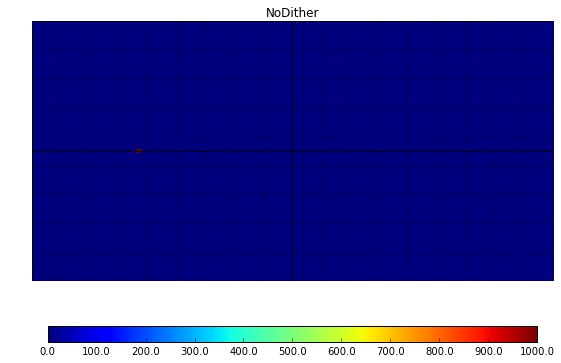

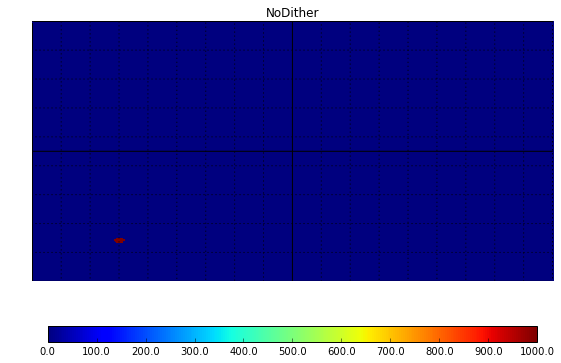

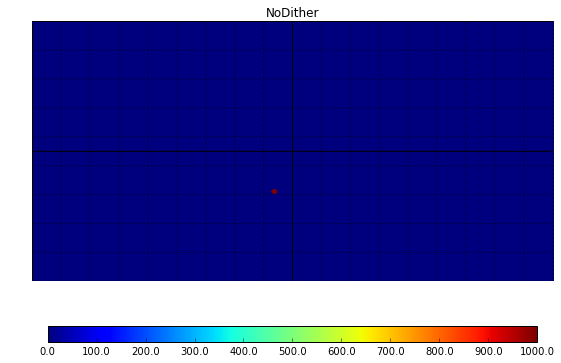

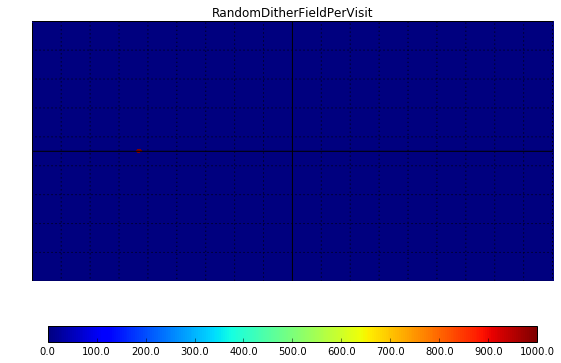

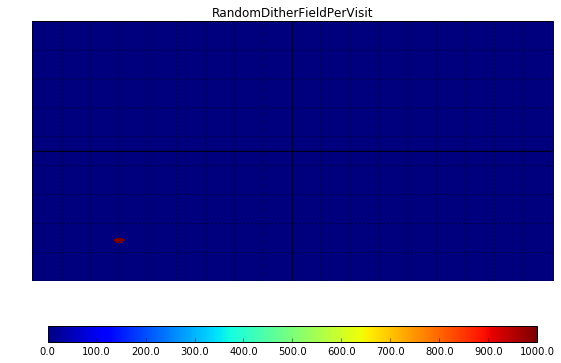

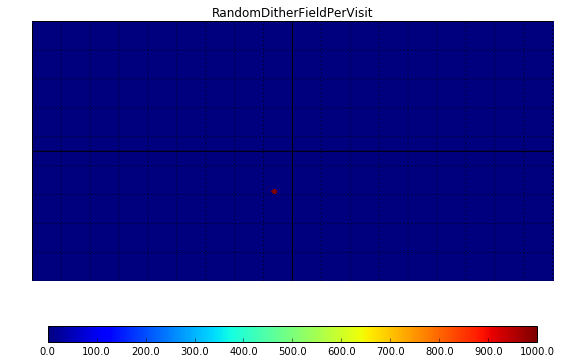

In [14]:
# plot region
#raRange= [np.degrees(ra)-20,np.degrees(ra)+20]
#decRange= [np.degrees(dec)-8,np.degrees(dec)+8]

diths= ['NoDither', 'RandomDitherFieldPerVisit']
for dither in diths:
    for ID in idsToConsider:
        #ID= ID[0]
        check= copy.deepcopy(coaddBundle[dither])
        check.metricValues.data[:]= 0
        check.metricValues.data[pixels_in_FOV[dither][ID]]= 1000   # artificial data
        # plot the FOV
        plt.clf()
        hp.cartview(check.metricValues.data, 
                    flip='astro', rot=(0,0,0) ,
                    #lonra= raRange, latra= decRange,
                    title= '', cbar=False)
        hp.graticule(dpar=20, dmer=20, verbose=False)
        plt.title(dither)
        ax = plt.gca()
        im = ax.get_images()[0]
        fig= plt.gcf()
        cbaxes = fig.add_axes([0.1, 0.01, 0.8, 0.04]) # [left, bottom, width, height]
        cb = plt.colorbar(im,  orientation='horizontal',
                          format= '%.1f', cax = cbaxes) 
        plt.show()

In [15]:
nside= 256

In [17]:
hpSlicer= slicers.HealpixSlicer(nside= nside)
hpSlicer.setupSlicer(simdata)    # slice data: know which pixels are observed in which visit
camera = LsstSimMapper().camera

#chipNames, obsIDs, expDates, fIDs= {}, {}, {}, {}
chipNamesUniqList, obsIDsUniqList, expDatesUniqList, fIDsUniqList= {}, {}, {}, {}

for dither in diths:
    print '##', dither
    chipNamesUniqList[dither], obsIDsUniqList[dither], expDatesUniqList[dither], fIDsUniqList[dither]= {}, {}, {}, {}
    for ID in idsToConsider:
        print '#ID ', ID
        #print chipNames[ID], obsIDs[ID], expDates[ID], fIDs[ID]
        chipNames, obsIDs, expDates, fIDs= [], [], [], []
        chipNamesUniqList[dither][ID], obsIDsUniqList[dither][ID], expDatesUniqList[dither][ID], fIDsUniqList[dither][ID]= [], [], [], []

        prevPercent= 0.
        startTime= time.time()
        totPixels= len(pixels_in_FOV[dither][ID])
        for p, pixel in enumerate(pixels_in_FOV[dither][ID]):  # run over all the pixels in the region
            pixRA, pixDec= hpSlicer._pix2radec(pixel)    # radians returned
            indObsInPixel = hpSlicer._sliceSimData(pixel)   # indices in simData for when an observation
                                                            # happened in this pixel      
            for index in indObsInPixel['idxs']:
                # get data from simdata
                # for identifying each visit
                
                expDate= simdata[index]['expDate']
                obsID= simdata[index]['obsHistID']
                fID= simdata[index]['fieldID']
                expMJD= simdata[index]['expMJD']
                if (dither=='NoDither'):
                    pointingRA= simdata[index]['fieldRA'] # radians
                    pointingDec= simdata[index]['fieldDec'] # radians
                    rotSkyPos= simdata[index]['rotSkyPos'] # radians
                    
                else:   # random translational dithers
                    pointingRA= simdata[index]['randomDitherFieldPerVisitRA'] # radians
                    pointingDec= simdata[index]['randomDitherFieldPerVisitDec'] # radians
                    rotSkyPos= simdata[index]['rotSkyPos'] # radians
                
                # set up for the finding the chips
                obs = ObservationMetaData(pointingRA= np.degrees(pointingRA), pointingDec= np.degrees(pointingDec),
                                          rotSkyPos= np.degrees(rotSkyPos), mjd= expMJD)
                chipsInVisit= chipNameFromRaDec(np.degrees(pixRA), np.degrees(pixDec),
                                                camera=camera, obs_metadata=obs)
                if chipsInVisit is not None:   # not 100% clear why some pixels don't have any chips.
                    obsIDs.append(obsID)
                    expDates.append(expDate)
                    chipNames.append(chipsInVisit)
                    fIDs.append(fID)

            percentDone= 100.*(p+1)/totPixels
            delPercent= percentDone-prevPercent
            if (delPercent>5):
                print '%f%% pixels done\nTime passed (min): %f'%(percentDone, (time.time()-startTime)/60.)
                prevPercent= percentDone
        obsIDs, expDates, fIDs, chipNames= np.array(obsIDs), np.array(expDates), np.array(fIDs), np.array(chipNames)

        for obs in np.unique(obsIDs):
            obsIDsUniqList[dither][ID].append(obs)
            ind= np.where(obsIDs==obs)[0]
            expDatesUniqList[dither][ID].append(np.unique(expDates[ind]))
            fIDsUniqList[dither][ID].append(np.unique(fIDs[ind]))
            chipNamesUniqList[dither][ID].append(np.unique(chipNames[ind]))
            
        print ''
        
for dither in ['RandomDitherFieldPerVisit_rotDithers']:   # rot dithers
    print '##', dither
    chipNamesUniqList[dither], obsIDsUniqList[dither], expDatesUniqList[dither], fIDsUniqList[dither]= {}, {}, {}, {}
    for ID in idsToConsider:
        print '#ID ', ID
        chipNames, obsIDs, expDates, fIDs= [], [], [], []
        chipNamesUniqList[dither][ID], obsIDsUniqList[dither][ID], expDatesUniqList[dither][ID], fIDsUniqList[dither][ID]= [], [], [], []

        prevPercent= 0.
        startTime= time.time()
        totPixels= len(pixels_in_FOV['RandomDitherFieldPerVisit'][ID])
        for p, pixel in enumerate(pixels_in_FOV['RandomDitherFieldPerVisit'][ID]):  # run over all the pixels in the region
            pixRA, pixDec= hpSlicer._pix2radec(pixel)    # radians returned
            indObsInPixel = hpSlicer._sliceSimData(pixel)   # indices in simData for when an observation
                                                            # happened in this pixel      
            for index in indObsInPixel['idxs']:
                # get data from simdata
                # for identifying each visit
                
                expDate= simdata[index]['expDate']
                obsID= simdata[index]['obsHistID']
                fID= simdata[index]['fieldID']
                expMJD= simdata[index]['expMJD']
                pointingRA= simdata[index]['randomDitherFieldPerVisitRA'] # radians
                pointingDec= simdata[index]['randomDitherFieldPerVisitDec'] # radians
                rotSkyPos= simdata[index]['rotSkyPos'] # radians
                parallacticAngle= simdata[index]['rotTelPos']-simdata[index]['rotSkyPos']
                ditheredRotSkyPos= simdata[index]['ditheredRotTelPos']-parallacticAngle
                rotSkyPos= ditheredRotSkyPos
                
                # set up for the finding the chips
                obs = ObservationMetaData(pointingRA= np.degrees(pointingRA), pointingDec= np.degrees(pointingDec),
                                          rotSkyPos= np.degrees(rotSkyPos), mjd= expMJD)
                chipsInVisit= chipNameFromRaDec(np.degrees(pixRA), np.degrees(pixDec),
                                                camera=camera, obs_metadata=obs)
                if chipsInVisit is not None:   # not 100% clear why some pixels don't have any chips.
                    obsIDs.append(obsID)
                    expDates.append(expDate)
                    chipNames.append(chipsInVisit)
                    fIDs.append(fID)

            percentDone= 100.*(p+1)/totPixels
            delPercent= percentDone-prevPercent
            if (delPercent>5):
                print '%f%% pixels done\nTime passed (min): %f'%(percentDone, (time.time()-startTime)/60.)
                prevPercent= percentDone
        obsIDs, expDates, fIDs, chipNames= np.array(obsIDs), np.array(expDates), np.array(fIDs), np.array(chipNames)

        for obs in np.unique(obsIDs):
            obsIDsUniqList[dither][ID].append(obs)
            ind= np.where(obsIDs==obs)[0]
            expDatesUniqList[dither][ID].append(np.unique(expDates[ind]))
            fIDsUniqList[dither][ID].append(np.unique(fIDs[ind]))
            chipNamesUniqList[dither][ID].append(np.unique(chipNames[ind]))
            
        print ''

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
## NoDither
#ID  2644


/Users/Humna/lsst/DarwinX86/sims_utils/12.0-13-g6534730/python/lsst/sims/utils/ModifiedJulianDate.py:188: UTCtoUT1Warning: UTC is outside of IERS table for UT1-UTC.
Returning UT1 = UTC for lack of a better idea
This warning was caused by calling ModifiedJulianDate.dut1

  category=UTCtoUT1Warning)


5.405405% pixels done
Time passed (min): 0.635100
10.810811% pixels done
Time passed (min): 1.181265
16.216216% pixels done
Time passed (min): 1.802206
21.621622% pixels done
Time passed (min): 2.398457
27.027027% pixels done
Time passed (min): 2.839664
32.432432% pixels done
Time passed (min): 3.246195
37.837838% pixels done
Time passed (min): 3.679796
43.243243% pixels done
Time passed (min): 4.071343
48.648649% pixels done
Time passed (min): 4.502466
54.054054% pixels done
Time passed (min): 4.907587
59.459459% pixels done
Time passed (min): 5.294086
64.864865% pixels done
Time passed (min): 5.677420
70.270270% pixels done
Time passed (min): 6.061910
75.675676% pixels done
Time passed (min): 6.424203
81.081081% pixels done
Time passed (min): 6.896639
86.486486% pixels done
Time passed (min): 7.671712
91.891892% pixels done
Time passed (min): 8.529890
97.297297% pixels done
Time passed (min): 9.322747

#ID  310
5.555556% pixels done
Time passed (min): 0.666622
11.111111% pixels done


/Users/Humna/lsst/DarwinX86/sims_coordUtils/12.0-4-g7de6cfa+29/python/lsst/sims/coordUtils/CameraUtils.py:325: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We will return only one of the chip names.  If you want both, try re-running with the kwarg allow_multiple_chips=True.
Offending chip names were ['R:4,0 S:0,2,A', 'R:4,0 S:0,2,B']
Offending pupil coordinate point was 0.020478886739 -0.020520975976

  category=MultipleChipWarning)


100.000000% pixels done
Time passed (min): 8.446553

#ID  1397
5.464481% pixels done
Time passed (min): 0.746050
10.928962% pixels done
Time passed (min): 1.350188
16.393443% pixels done
Time passed (min): 1.795342
21.857923% pixels done
Time passed (min): 2.220994
27.322404% pixels done
Time passed (min): 2.709929
32.786885% pixels done
Time passed (min): 3.334084
38.251366% pixels done
Time passed (min): 3.879374
43.715847% pixels done
Time passed (min): 4.387289
49.180328% pixels done
Time passed (min): 4.875917
54.644809% pixels done
Time passed (min): 5.353932
60.109290% pixels done
Time passed (min): 5.882108
65.573770% pixels done
Time passed (min): 6.354615
71.038251% pixels done
Time passed (min): 6.812891
76.502732% pixels done
Time passed (min): 7.238569
81.967213% pixels done
Time passed (min): 7.632708
87.431694% pixels done
Time passed (min): 7.990579
92.896175% pixels done
Time passed (min): 8.518846
98.360656% pixels done
Time passed (min): 9.237961



2644
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 179
-- Min number of chips added by any given visit: 3
-- Total number of chips (across all visits to be simulated): 44970
1397
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 177
-- Min number of chips added by any given visit: 3
-- Total number of chips (across all visits to be simulated): 43670
310
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 162
-- Min number of chips added by any given visit: 1
-- Total number of chips (across all visits to be simulated): 35737


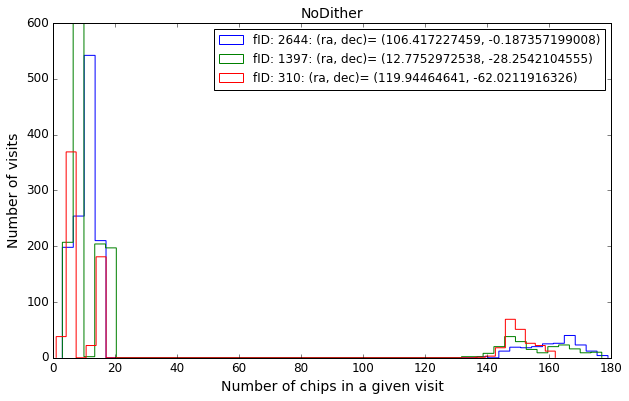

2644
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 168
-- Min number of chips added by any given visit: 1
-- Total number of chips (across all visits to be simulated): 29009
1397
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 168
-- Min number of chips added by any given visit: 1
-- Total number of chips (across all visits to be simulated): 27168
310
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 155
-- Min number of chips added by any given visit: 1
-- Total number of chips (across all visits to be simulated): 23689


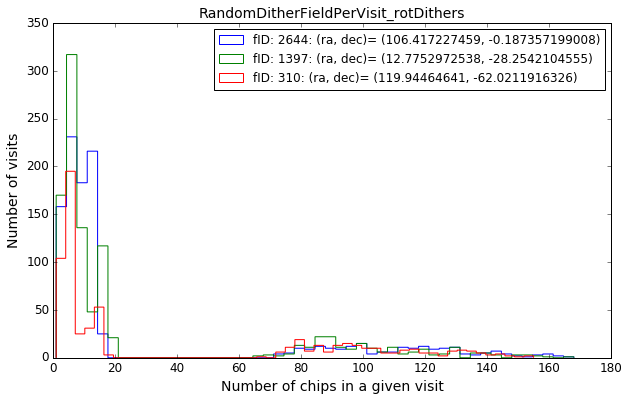

2644
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 165
-- Min number of chips added by any given visit: 1
-- Total number of chips (across all visits to be simulated): 29042
1397
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 162
-- Min number of chips added by any given visit: 1
-- Total number of chips (across all visits to be simulated): 26930
310
** All chips (including wavefront) **
-- Max number of chips added by any given visit: 159
-- Min number of chips added by any given visit: 1
-- Total number of chips (across all visits to be simulated): 23742


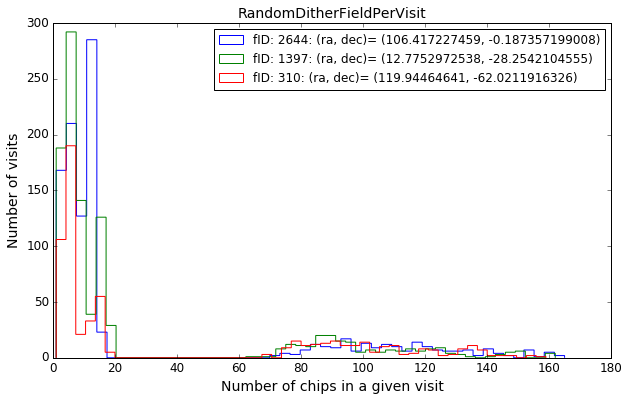

In [18]:
for dith in chipNamesUniqList:
    for ID in chipNamesUniqList['NoDither']:
        index= np.where(ids==ID)[0]
        ra= np.degrees(pointingRAs[index])[0]
        dec= np.degrees(pointingDecs[index])[0]
    
        numChipsAll= []
        numChipToSim= []
        print ID
        for i in range(len(obsIDsUniqList[dith][ID])):

            temp= chipNamesUniqList[dith][ID][i]

            numChipsAll.append(len(temp))

            #temp= lis(set(temp)-set(wavefront))
            #numChipToSim.append(len(temp))

        print '** All chips (including wavefront) **'
        print '-- Max number of chips added by any given visit: %d'%(max(numChipsAll))
        print '-- Min number of chips added by any given visit: %d'%(min(numChipsAll))
        print '-- Total number of chips (across all visits to be simulated): %d'%(sum(numChipsAll))   
        #print '-- Total number of chips * cos(dec): %d\n'%(sum(numChipsAll)/np.cos(np.radians(dec))   )

        bins= 50
        alpha= 1 #0.2
        fontsize= 14
        
        plt.hist(numChipsAll, histtype= 'step', label= 'fID: %s: (ra, dec)= (%s, %s)'%(ID, ra, dec), 
                                                                                       alpha= alpha, bins= bins)
        #plt.hist(numChipToSim, label= 'NonWaveFront', alpha= alpha, bins= bins)
    #plt.title('fID: %s'%key, fontsize= fontsize)
    plt.title(dith, fontsize= fontsize)
    plt.legend()
    plt.xlabel('Number of chips in a given visit', fontsize= fontsize)
    plt.ylabel('Number of visits', fontsize= fontsize)
    plt.legend(loc= 1)#bbox_to_anchor= (1.5,0.5))
    plt.tick_params(axis='x', labelsize=fontsize-2)
    plt.tick_params(axis='y', labelsize=fontsize-2)
    fig = plt.gcf()
    fig.set_size_inches(10, 6)


    plt.show()